In [1]:
import fiona
import pandas as pd
import geopandas as gpd
import collections
import numpy as np
from tqdm.notebook import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt
import difflib
import re
import collections
from fuzzywuzzy import fuzz
import shapely
from IPython.display import display
mpl.rcParams['figure.dpi'] = 144

/Users/till/.pyenv/versions/3.9.2/envs/geomapping/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
catchments = gpd.read_file('data/catchments/catchments_consolidated.shp')
catchments.head()

,company,name,reference,comment,identifier,geometry
0,scottish_water,Berneray Borve DOA,DOA002593,None,9962da64df,"POLYGON ((91881.463 880838.237, 91827.086 8808..."
1,scottish_water,GALA ST DOA,DOA002587,None,52bd485922,"POLYGON ((364841.140 620063.110, 364842.000 62..."
2,scottish_water,Pencaitland ST DOA,DOA002595,None,c4016cc092,"POLYGON ((344251.352 669022.993, 344314.821 66..."
3,scottish_water,Thornwood Pk DOA,DOA002596,None,c8735aca6a,"POLYGON ((352053.670 615656.280, 351986.800 61..."
4,scottish_water,The Woll DOA,DOA002600,None,84b8487a96,"POLYGON ((346439.540 621876.640, 346453.425 62..."


In [3]:
# Load the data.
uwwtps = gpd.GeoDataFrame(pd.read_csv('data/waterbase_consolidated.csv'))

# Identify the treatment plants that were inactive in the most recent report.
inactive = []
for uwwCode, subset in uwwtps.groupby('uwwCode'):
    subset = subset.sort_values('year')
    item = subset.iloc[-1]
    if item.uwwState == 'inactive':
        inactive.append(item)
        
inactive = pd.DataFrame(inactive)
inactive

,uwwState,rptMStateKey,uwwCode,uwwName,uwwLatitude,uwwLongitude,uwwLoadEnteringUWWTP,uwwCapacity,version,year
1933,inactive,UK,UKENAN_AW_TP000070,COWBIT STW,52.754400,-0.092370,0.0,0.0,2,2008
6091,inactive,UK,UKENAN_AW_TP000085,DUXFORD STW,52.094700,0.120497,542.0,3275.0,5,2012
6301,inactive,UK,UKENAN_AW_TP000134,HOLBROOK STW,51.970400,1.161650,1942.0,2009.0,5,2012
6610,inactive,UK,UKENAN_AW_TP000198,NORTH SOMERCOTES STW,53.462200,0.135240,1288.0,3194.0,5,2012
12416,inactive,UK,UKENAN_AW_TP000212,PORINGLAND STW,52.557848,1.368007,0.0,5391.0,8,2018
...,...,...,...,...,...,...,...,...,...,...
9587,inactive,UK,UKSC_TP00211,SPEAN BRIDGE/ROYBRIDGE WwTW,56.894030,-4.901360,1099.0,2510.0,7,2016
9058,inactive,GB,UKWAWA_WW_TP000009,RAGLAN STW CHEPSTOW ROAD RAGLAN STW,51.760900,-2.848450,1210.0,1300.0,6,2014
3510,inactive,UK,UKWAWA_WW_TP000037,HIRWAUN STW HIRWAUN RHONDDA STW,51.749190,-3.541560,1436.0,1436.0,2,2008
9509,inactive,UK,UKWAWA_WW_TP000071,LLANINA WWTW STW,52.208838,-4.337460,7903.0,6608.0,7,2016


In [4]:
# Drop treatment works that are inactive.
print(f'starting with {uwwtps.uwwCode.nunique()} treatment plants')
uwwtps = uwwtps.loc[~np.in1d(uwwtps.uwwCode, inactive.uwwCode)]
print(f'retained {uwwtps.uwwCode.nunique()} treatment plants after removing inactive plants')

# Drop treatment works that never provided any load or capacity data.
grouped = uwwtps.groupby('uwwCode')
f = (grouped.uwwCapacity.max() > 0) | (grouped.uwwLoadEnteringUWWTP.max() > 0)
uwwtps = uwwtps.loc[np.in1d(uwwtps.uwwCode, f.index)]
print(f'retained {uwwtps.uwwCode.nunique()} treatment plants after removing plants without load or capacity')

# Group by treatment code and take the most recent data.
uwwtps = uwwtps.sort_values('year').groupby('uwwCode').last().reset_index()

# Reproject into the british national grid.
uwwtps['geometry'] = gpd.points_from_xy(uwwtps.uwwLongitude, uwwtps.uwwLatitude)
uwwtps = gpd.GeoDataFrame(uwwtps).set_crs('epsg:4326').to_crs('epsg:27700')

print(len(uwwtps))
uwwtps.head()

starting with 1990 treatment plants
retained 1857 treatment plants after removing inactive plants
retained 1857 treatment plants after removing plants without load or capacity
1857


,uwwCode,uwwState,rptMStateKey,uwwName,uwwLatitude,uwwLongitude,uwwLoadEnteringUWWTP,uwwCapacity,version,year,geometry
0,UKENAN_AW_TP000001,active,UK,ACLE STW,52.632768,1.555557,3741.0,4000.0,8,2018,POINT (640698.000 309826.164)
1,UKENAN_AW_TP000002,active,UK,ALCONBURY STW,52.364693,-0.249934,3751.0,5170.0,8,2018,POINT (519260.055 275512.075)
2,UKENAN_AW_TP000003,active,UK,ALFORD STW,53.260330,0.187425,3922.0,4650.0,8,2018,POINT (546005.973 375935.076)
3,UKENAN_AW_TP000004,active,UK,ANWICK STW,53.035705,-0.338785,34938.0,34938.0,8,2018,POINT (511488.999 350004.056)
4,UKENAN_AW_TP000005,active,UK,ASHBROOK STW,51.935071,-0.253607,3535.0,3837.0,8,2018,POINT (520160.093 227725.086)


# Physical distances.

In [5]:
distances = []
for _, catchment in tqdm(catchments.iterrows(), total=len(catchments)):
    distances.append(uwwtps.distance(catchment.geometry, align=False))
# Cast to a dataframe.
distances = np.asarray(distances)
distances = pd.DataFrame(distances, index=catchments.identifier, columns=uwwtps.uwwCode)
distances.shape

  0%|          | 0/7504 [00:00<?, ?it/s]

(7504, 1857)

In [6]:
thresholds = np.logspace(1, 3, 50)
num_uwwtps_near_catchment = []
num_catchments_near_uwwtp = []
for threshold in thresholds:
    near = distances < threshold
    num_uwwtps_near_catchment.append(near.sum(axis=1))
    num_catchments_near_uwwtp.append(near.sum(axis=0))
    
num_uwwtps_near_catchment = np.asarray(num_uwwtps_near_catchment)
num_catchments_near_uwwtp = np.asarray(num_catchments_near_uwwtp)

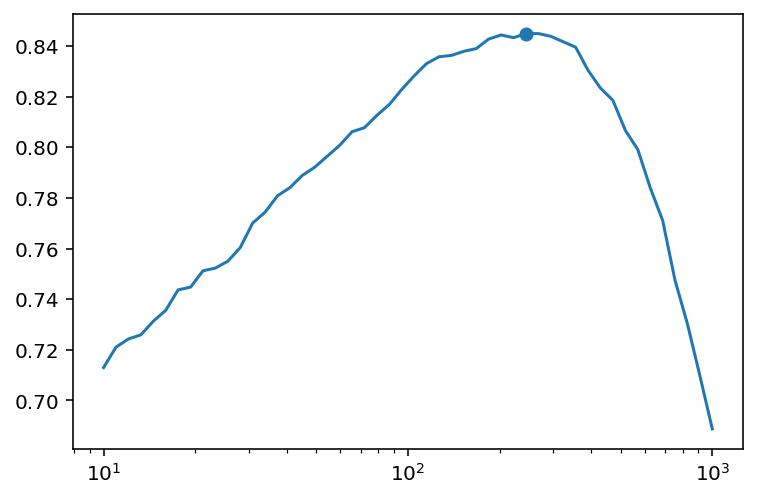

In [7]:
fig, ax = plt.subplots()
ys = [
    # np.mean(num_uwwtps_near_catchment == 1, axis=1), 
    np.mean(num_catchments_near_uwwtp == 1, axis=1),
]
for y in ys:
    line, = ax.plot(thresholds, y)
    i = np.argmax(y)
    ax.scatter(thresholds[i], y[i], color=line.get_color())
ax.set_xscale('log')

# Rule-based matching

  0%|          | 0/50 [00:00<?, ?it/s]

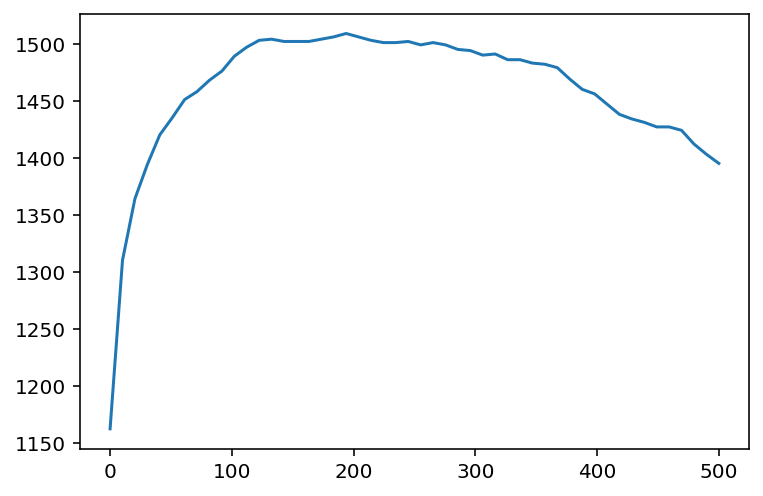

In [8]:
# Find all combinations of catchments and treatment plants where both the treatment plant 
# and the catchment are associated with exactly one other treatment plant/catchment at zero distance.
thresholds = thresholds = np.linspace(0, 500, 50)
num = []
for threshold in tqdm(thresholds):
    binary = (distances <= threshold).values
    f = (binary.sum(axis=1) == 1)[:, None] & ((binary).sum(axis=0) == 1) & binary
    catchment_idx, stp_idx = np.nonzero(f)
    num.append(len(catchment_idx))
    
plt.plot(thresholds, num)

In [9]:
def normalise_name(value):
    """
    Normalise treatment names.
    """
    if pd.isnull(value):
        return value
    # Drop all special characters.
    value, _ = re.subn(r'[\(\)\[\]\{\}\.\&-]', '', value.lower())
    # Drop stw and wwtw (often suffixes).
    value, _ = re.subn(r'\b(stw|wwtw|doa|wrw|bucks)\b', '', value)
    # Drop all whitespace.
    value, _ = re.subn(r'\s', '', value)
    return value

In [10]:
# Find all combinations of catchments and treatment plants where both the treatment plant 
# and the catchment are associated with exactly one other treatment plant/catchment below
# a given distance.
threshold = 100
binary = (distances <= threshold).values
f = (binary.sum(axis=1) == 1)[:, None] & ((binary).sum(axis=0) == 1) & binary

# Validate uniqueness.
np.testing.assert_array_less(f.sum(axis=0), 2)
np.testing.assert_array_less(f.sum(axis=1), 2)

# Add all treatment works where the normalised names are identical and the distance is less
# than some other threshold.
f |= (catchments['name'].apply(normalise_name).values[:, None] == uwwtps.uwwName.apply(normalise_name).values) \
    & (distances.values <= 2500)

catchment_idx, stp_idx = np.nonzero(f)

auto_matched = pd.concat([
    uwwtps.iloc[stp_idx].reset_index(drop=True), 
    catchments.iloc[catchment_idx].reset_index(drop=True).drop('geometry', axis=1)
], axis=1)[['identifier', 'name', 'uwwCode', 'uwwName']]
auto_matched

,identifier,name,uwwCode,uwwName
0,9f48312695,Whitburn DOA,UKSC_TP00194,WHITBURN WWTW
1,de19428017,Gorebridge DOA,UKSC_TP00086,GOREBRIDGE WWTW
2,131d6e3698,Ormiston DOA,UKSC_TP00152,ORMISTON WWTW
3,fbd2f925e5,Avse Pfi - Edinburgh DOA,UKSC_TP00070,"EDINBURGH, SEAFIELD WWTW"
4,2a38994f73,Dunbar DOA,UKSC_TP00213,DUNBAR (SOUTH) STW
...,...,...,...,...
1579,0c64fe5f19,Masham,UKENNE_YW_TP000027,MASHAM STW
1580,2dd8eabd32,North Ferriby,UKENNE_YW_TP000110,NORTH FERRIBY STW
1581,a8dd4d5ec6,Denaby,UKENNE_YW_TP000073,DENABY STW
1582,b9bb7067a2,Lindholme,UKENMI_YW_TP000167,HMP LINDHOLME & MOORLAND


In [11]:
# Remove all treatment works from South West Water and Northern Ireland Water.
excluded = uwwtps[
    uwwtps.uwwCode.str.startswith('UKENSW_SWS') | 
    uwwtps.uwwCode.str.startswith('UKNI') | 
    uwwtps.uwwCode.str.startswith('UKGIB')
]
excluded = excluded[['uwwCode', 'uwwName']]
excluded

,uwwCode,uwwName
1084,UKENSW_SWS_TP000001,AXMINSTER STW
1085,UKENSW_SWS_TP000002,BARNSTAPLE STW
1086,UKENSW_SWS_TP000003,BERE ALSTON STW
1087,UKENSW_SWS_TP000004,BODMIN (NANSTALLON) STW
1088,UKENSW_SWS_TP000005,BODMIN (SCARLETTS WELL) STW
...,...,...
1523,UKNI_TP00094,Killinchy
1524,UKNI_TP00095,Portaferry
1525,UKNI_TP00096,Creagh
1526,UKNI_TP00097,Donaghmore


In [12]:
manual_matched = pd.DataFrame([
    ('214873b5cf', 'UU-09-SC47-DAVYH', 'UKENNW_UU_TP000042', 'Manchester and Salford (Davyhulme)STW'),
    ('d793a815d9', 'UU-10-SC50-ROYTO', 'UKENNW_UU_TP000105', 'ROYTON STW'),
    ('b65d2eebc7', 'UU-10-SC51-FAILS', 'UKENNW_UU_TP000048', 'FAILSWORTH STW'),
    ('bb6ca16304', 'UU-10-SC54-HAZEL', 'UKENNW_UU_TP000058', 'HAZEL GROVE STW'),
    ('59bd836fc3', 'UU-10-SC54-STOCK', 'UKENNW_UU_TP000116', 'STOCKPORT STW'),
    # ('fd41986341', 'Billericay', 'UKENAN_AW_TP000020', 'BILLERICAY STW'),
    ('5900c96825', 'Shenfield and Hutton', 'UKENAN_AW_TP000230', 'SHENFIELD STW'),
    ('4647e75f9e', 'CARDIFF BAY', 'UKWAWA_WW_TP000026', 'CARDIFF STW'),
    # These two are the same treatment work.
    ('cd33d70a80', 'Catterick Village', 'UKENNE_YW_TP000007', 'CATTERICK STW'),
    ('cd33d70a80', 'Catterick Village', 'UKENNE_YW_TP000008', 'COLBURN STW'),
    ('d8270e9ad8', 'UU-11-SC56-NTHWI', 'UKENNW_UU_TP000097', 'NORTHWICH STW'),
    # Cuddington has been decommissioned (https://www.unitedutilities.com/about-us/cheshire/).
    ('d8270e9ad8', 'UU-11-SC56-NTHWI', 'UKENNW_UU_TP000040', 'CUDDINGTON STW'),
    #('e68d274661', 'PYE BRIDGE (WRW)', 'UKENMI_ST_TP000269', 'PYE BRIDGE STW'),
    #('fdc9ee9622', 'PINXTON (WRW)', 'UKENMI_ST_TP000266', 'PINXTON STW'),
    #('06a0b00a92', 'RADCLIFFE-ON-TRENT (WRW)', 'UKENMI_ST_TP000174', 'RADCLIFFE ON TRENT STW'),
    # Cotgrave feeds into Radcliffe.
    # https://www.nottinghamshire.gov.uk/planningsearch/DisplayImage.aspx?doc=cmVjb3JkX251bWJlcj02OTU4JmZpbGVuYW1lPVxcbnMwMS0wMDI5XGZpbGVkYXRhMiRcREIwMy0wMDMwXFNoYXJlZEFwcHNcRExHU1xQbGFuc1xQTEFOTklOR1xTY3ItMzY0OFxSYWRjbGlmZmUgRUlBIFNjcmVlbmluZyBPcGluaW9uIFJlcXVlc3QucGRmJmltYWdlX251bWJlcj01JmltYWdlX3R5cGU9cGxhbm5pbmcmbGFzdF9tb2RpZmllZF9mcm9tX2Rpc2s9MTIvMDQvMjAxNyAxMDozMzo0MQ==
    (None, None, 'UKENMI_ST_TP000064', 'COTGRAVE STW'),
    #('c9a65352a1', 'SUTTON IN ASHFIELD (WRW)', 'UKENMI_ST_TP000210', 'SUTTON IN ASHFIELD STW'),
    ('fb13da240a', 'MANSFIELD-BATH LANE (WRW)', 'UKENMI_ST_TP000143', 'MANSFIELD STW'),
    # https://goo.gl/maps/pFhJy3ZAxyABKwWc6
    ('9fcbac5ecc', 'STOKE BARDOLPH (WRW)', 'UKENMI_ST_TP000163', 'NOTTINGHAM STW'),
    ('7be11f772b', 'BEESTON -LILAC GROVE (WRW)', 'UKENMI_ST_TP000025', 'BEESTON STW'),
    ('c861b125a1', 'STRATFORD-MILCOTE (WRW)', 'UKENMI_ST_TP000206', 'STRATFORD  STW'),
    # Long Marston has been decommissioned.
    # https://waterprojectsonline.com/custom_case_study/pebworth-long-marston-stratford-upon-avon-transfer/
    (None, None, 'UKENMI_ST_TP000135', 'LONG MARSTON STW'),
    #('1912dfca82', 'KILBURN (WRW)', 'UKENMI_ST_TP000121', 'KILBURN STW'),
    #('ac65ac5cfa', 'MAREHAY (WRW)', 'UKENMI_ST_TP000145', 'MAREHAY STW'),
    #('5dc01d2f15', 'BLACKBIRDS STW', 'UKENTH_TWU_TP000021', 'BLACKBIRDS WWTW'),
    ('01bf76d616', 'MAPLE LODGE STW', 'UKENTH_TWU_TP000106', 'MAPLE LODGE, BUCKS STW"'),
    # ('2b88b055de', 'Redacre', 'UKENNE_YW_TP000116', 'REDACRE STW'),
    ('034de6cd3b', 'Eastwood', 'UKENNE_YW_TP000079', 'TODMORDEN   STW'),
    # Same treatment work.
    #('8a5a88fe31', 'Balby', 'UKENNE_YW_TP000149', 'BALBY STW'),
    #('8a5a88fe31', 'Balby', 'UKENMI_YW_TP000001', 'BALBY STW'),
    # ('3e38ccd74a', 'Ely', 'UKENAN_AW_TP000091', 'ELY STW'),
    # ('63c5a36a44', 'Ely-New', 'UKENAN_AW_TP000092', 'ELY NEW STW'),
    #('5968074192', 'Huddersfield', 'UKENNE_YW_TP000094', 'HUDDERSFIELD STW'),
    ('c64f685e8b', 'Neiley', 'UKENNE_YW_TP000109', 'HOLMFIRTH   STW'),
    ('7e5b0d4c85', 'UU-05-SC28-BLACK', 'UKENNW_UU_TP000018', 'BLACKBURN STW'),
    ('ccad6a0777', 'UU-05-SC28-DARWE', 'UKENNW_UU_TP000041', 'DARWEN STW'),
    ('3bbfed4b3f', 'UU-06-SC35-HUYTO', 'UKENNW_UU_TP000066', 'HUYTON STW'),
    ('a83266015d', 'UU-06-SC35-LIVER', 'UKENNW_UU_TP000080', 'LIVERPOOL SOUTH [WOOLTON]) STW'),
    ('0d2d457ce0', 'MARGATE AND BROADSTAIRS', 'UKENSO_SW_TP000019', 'BROADSTAIRS/MARGATE OUT CSM (Weatherlees B)'),
    ('bbd09a27de', 'WEATHERLEES HILL', 'UKENSO_SW_TP000022', 'RAMSGATE, SANDWICH, DEAL   STW"'),
    ('00e1c4c53b', 'UU-09-SC46-ECCLE', 'UKENNW_UU_TP000046', 'ECCLES STW'),
    ('feab30c503', 'UU-07-SC40-WORSL', 'UKENNW_UU_TP000140', 'WORSLEY STW'),
    # Same STW.
    ('1a88d8eed9', 'ABINGDON STW', 'UKENTH_TWU_TP000001', 'ABINGDON (OXON STW)'),
    # ('1a88d8eed9', 'ABINGDON STW', 'UKENTH_TWU_TP000165', 'ABINGDON STW'),
    #('0df32b1f38', 'Carbarns DOA', 'UKSC_TP00034', 'CARBARNS S.T.W.'),
    #('6473cb2e86', 'Folkton', 'UKENNE_YW_TP000148', 'FOLKTON STW'),
    #('79f3331fdb', 'HAM HILL', 'UKENSO_SW_TP000052', 'HAM HILL STW'),
    ('b428837dda', 'NAGS HEAD LANE STW', 'UKENTH_TWU_TP000115', 'NAGS HEAD LANE ( BRENTWOOD STW'),
    ('3d27aa0af3', 'RIVERSIDE STW', 'UKENTH_TWU_TP000125', 'LONDON (Riverside STW)'),
    #('9658914167', 'Poppyhill', 'UKENAN_AW_TP000211', 'POPPY HILL STW'),
    ('cee1fb4e33', 'UU-07-SC40-GLAZE', 'UKENNW_UU_TP000053', 'GLAZEBURY STW'),
    ('0a4fc58758', 'UU-07-SC40-LEIGH', 'UKENNW_UU_TP000078', 'LEIGH STW'),
    ('3b82554080', 'UU-07-SC39-BOLTO', 'UKENNW_UU_TP000019', 'BOLTON STW'),
    ('51bdbc0969', 'UU-07-SC37-BURYZ', 'UKENNW_UU_TP000026', 'BURY STW'),
    ('f08942bc5a', 'UU-10-SC52-ASHUL', 'UKENNW_UU_TP000007', 'ASHTON-UNDER-LYNE STW'),
    ('5d269b4c58', 'UU-10-SC52-DUKIN', 'UKENNW_UU_TP000044', 'DUKINFIELD STW'),
    ('b24ca82746', 'RHIWSAESON (NEW)', 'UKWAWA_WW_TP000024', 'RHIWSAESON STW RHIWSAESON LLANTRI STW'),
    ('a7ecedaef5', 'COSLECH', 'UKWAWA_WW_TP000020', 'SOUTH ELY VALLEY   STW'),
    ('2e2e1b5104', 'Dalscone DOA', 'UKSC_TP00053', 'DALSCONE S.T.W. (NEW)'),
    ('2e2e1b5104', 'Dalscone DOA', 'UKSC_TP00054', 'DALSCONE S.T.W.  (OLD)'),
    ('5f66794c55', 'Whilton', 'UKENAN_AW_TP000286', 'DAVENTRY   STW'),
    ('613c6a0818', 'BAKEWELL, PICKORY CORNER (WRW)', 'UKENMI_ST_TP000013', 'BAKEWELL STW'),
    ('2eb71ffcfc', 'BOTTESFORD-STW', 'UKENMI_ST_TP000033', 'BOTTESFORD STW'),
    ('e4a961fba1', 'KEMPSEY WORKS (WRW)', 'UKENMI_ST_TP000119', 'KEMPSEY STW'),
    ('fc53d47ef6', 'CLAYMILLS (WRW)', 'UKENMI_ST_TP000056', 'BURTON ON TRENT   STW'),
    # Nothing in the vicinity.
    (None, None, 'UKENMI_ST_TP000127', 'KNIGHTON STW'),
    (None, None, 'UKENMI_ST_TP000133', 'LLANIDLOES STW'),
    ('54e25cb6a9', 'MELTON (WRW)', 'UKENMI_ST_TP000152', 'MELTON MOWBRAY STW'),
    # Nothing.
    (None, None, 'UKENMI_ST_TP000161', 'NEWTOWN STW'),
    ('b0753764b4', 'STANLEY DOWNTON (WRW)', 'UKENMI_ST_TP000208', 'STROUD STW'),
    ('b11e60b850', 'ROUNDHILL (WRW)', 'UKENMI_ST_TP000180', 'STOURBRIDGE & HALESOWEN   STW'),
    ('ffe8483a02', 'ASH VALE STW', 'UKENTH_TWU_TP000009', 'ASH VALE, STRATFORD ROAD, NORTH STW"'),
    ('e526b8f3b6', 'BRACKNELL STW', 'UKENTH_TWU_TP000025', 'BRACKNELL, HAZELWOOD LANE, BINF STW"'),
    ('29d52395a3', 'UU-04-SC21-PREST', 'UKENNW_UU_TP000102', 'PRESTON (CLIFTON MARSH) STW'),
    ('c1e0195f63', 'WINDSOR STW', 'UKENTH_TWU_TP000152', 'WINDSOR, HAM ISLAND, OLD WINDSO STW"'),
    ('743841f528', 'CAMBERLEY STW', 'UKENTH_TWU_TP000033', 'CAMBERLEY, CAMBERLEY, SURREY STW"'),
    ('80c85e78c6', 'DORCHESTER STW', 'UKENTH_TWU_TP000056', 'DORCHESTER STW (OXON)'),
    ('0f5561c4b9', 'STANFORD RIVERS STW', 'UKENTH_TWU_TP000136', 'STANFORD RIVERS, ONGAR, ESSEX STW"'),
    ('45b2ebfd2f', 'UU-03-SC17-KRKLO', 'UKENNW_UU_TP000151', 'KIRKBY LONSDALE STW HUMUS TANK EFFLUENT'),
    ('935c2734be', 'MARLBOROUGH STW', 'UKENTH_TWU_TP000108', 'MARLBOROUGH, MARLBOROUGH, WILTS STW"'),
    ('ba3e9907f2', 'EARLSWOOD STW', 'UKENTH_TWU_TP000123', 'REIGATE STW'),
    ('98a14c9923', 'STANTON - DERBYSHIRE (WRW)', 'UKENMI_ST_TP000201', 'STANTON   STW'),
    ('1d9dcc765f', 'WORMINGHALL STW', 'UKENTH_TWU_TP000158', 'WORMINGHALL, WORMINGHALL, BUCKS STW"'),
    ('a087889829', 'SUTTON BONNINGTON (WRW)', 'UKENMI_ST_TP000278', 'SUTTON BONINGTON STW, FE"'),
    ('4c0aab484f', 'STANSTED MOUNTFITCHET STW', 'UKENTH_TWU_TP000137', 'STANSTED MOUNTFITCHET, STANSTED STW"'),
    ('0d09ae579a', 'RAMSBURY STW', 'UKENTH_TWU_TP000121', 'RAMSBURY, RAMSBURY, MARLBOROUGH STW"'),
    ('0de7c65bea', 'UU-06-SC31-HSKBK', 'UKENNW_UU_TP000060', 'HESKETH BANK STW'),
    ('a8d4ccb494', 'CHICKENHALL EASTLEIGH', 'UKENSO_SW_TP000013', 'EASTLEIGH   STW'),
    ('0340b3c3c4', 'WALSALL WOOD (WRW)', 'UKENMI_ST_TP000221', 'WALSALL NORTH   STW'),
    ('47aebf7f1e', 'UU-03-SC18-LANCA', 'UKENNW_UU_TP000076', 'LANCASTER (STODDAY) STW'),
    ('95fa57e680', 'MILL GREEN STW', 'UKENTH_TWU_TP000111', 'MILL GREEN, HATFIELD, HERTS STW"'),
    ('f01161329e', 'SLOUGH STW', 'UKENTH_TWU_TP000133', 'SLOUGH, WOOD STW"'),
    ('01565d4110', 'FINSTOCK STW', 'UKENTH_TWU_TP000067', 'FINSTOCK, FINSTOCK, OXON STW"'),
    ('15831f78a8', 'WOTTON UNDER EDGE STW CATCHMENT', 'UKENSW_WXW_TP000109', 'WOTTON UNDER EDGE STW'),
    ('8237f30715', 'STANFORD IN THE VALE STW', 'UKENTH_TWU_TP000169', 'Standford in the Vale STW'),
    ('a1e551a2fd', 'MORESTEAD ROAD WINCHESTER', 'UKENSO_SW_TP000003', 'WINCHESTER CENTRAL AND SOUTH (MORESTEAD) STW'),
    ('3b917f6c5f', 'BASINGSTOKE STW', 'UKENTH_TWU_TP000013', 'BASINGSTOKE, WILDMOOR, BASINGST STW"'),
    ('1903e1316b', 'FULLERTON', 'UKENSO_SW_TP000006', 'ANDOVER STW'),
    ('82d89b13a2', 'Fochabers DOA', 'UKSC_TP00077', 'FOCHABERS WWTP'),
    ('965a041c6a', 'THAME STW', 'UKENTH_TWU_TP000140', 'THAME, THAME, OXON STW"'),
    ('19fe3ba781', 'GODALMING STW', 'UKENTH_TWU_TP000071', 'GODALMING, UNSTEAD, GODALMING, STW"'),
    ('bb40f7f215', 'UU-03-SC16-GRNGS', 'UKENNW_UU_TP000055', 'GRANGE-OVER-SANDS STW'),
    ('60cd9fef4c', 'DRENEWYDD - OSWESTRY (WRW)', 'UKENMI_ST_TP000166', 'OSWESTRY DRENEWYDD STW'),
    ('9edf9e05e3', 'HIGHER HEATH-PREES (WRW)', 'UKENMI_ST_TP000268', 'PREES HIGHER HEATH STW'),
    ('5b6ed3d068', 'RUSHMOOR (WRW)', 'UKENMI_ST_TP000184', 'TELFORD   STW'),
    ('d8b6f988ea', 'CHESHAM STW', 'UKENTH_TWU_TP000039', 'CHESHAM, BUCKS STW"'),
    ('04a2d621cd', 'UU-07-SC40-TYLDE', 'UKENNW_UU_TP000120', 'TYLDESLEY STW'),
    ('5353ff23aa', 'APPLETON STW', 'UKENTH_TWU_TP000006', 'APPLETON, ABINGDON, OXON STW"'),
    # No good match.
    (None, None, 'UKSC_TP00011', 'ANNANDALE WATER MSA S.T.W.'),
    (None, None, 'UKENTH_TWU_TP000162', 'ALDERSHOT MILITARY STW'),
    ('8fccf79af1', 'WHITE WALTHAM STW', 'UKENTH_TWU_TP000150', 'WHITE WALTHAM, WHITE WALTHAM, B STW"'),
    ('a2a6cca4f6', 'POWICK (WRW)', 'UKENMI_ST_TP000173', 'POWICK NEW STW'),
    ('c33bed15a5', 'Knostrop Merge High + Low', 'UKENNE_YW_TP000098', 'LEEDS (KNOSTROP) STW'),
    # No good match.
    (None, None, 'UKSC_TP00201', 'FASLANE STW'),
    (None, None, 'UKSC_TP00085', 'GLENEAGLES STW'),
    ('11d6a4c3d9', 'HAYDEN (WRW)', 'UKENMI_ST_TP000256', 'CHELTENHAM STW'),
    ('5b3b7769c8', 'Withernsea No. 2', 'UKENNE_YW_TP000139', 'WITHERNSEA OUTFALL STW'),
    ('864e5eaa8d', 'TRIMDON VILLAGE STW NZ37346301', 'UKENNE_NU_TP000052', 'TRIMDON VILLAGE STW'),
    ('d31b19b35b', 'NORTH TIDWORTH STW CATCHMENT', 'UKENSW_VE_TP000001', 'TIDWORTH GARRISON STW FE'),
    ('f00ad841f9', 'PEACEHAVEN', 'UKENSO_SW_TP000126', 'PEACEHAVEN WASTEWATER TREATMENT WKS'),
    (None, None, 'UKWAWA_WW_TP000128', 'BLUESTONE LEISURE CANASTON'),
    (None, None, 'UKENMI_ST_TP000227', 'WELSHPOOL STW'),
    (None, None, 'UKSC_TP00171', 'SOUTHERNESS STW'),
    ('d832f51e93', 'CYNON', 'UKWAWA_WW_TP000011', 'MERTHYR TYDFIL   STW'),

], columns=['identifier', 'name', 'uwwCode', 'uwwName'])

matched = pd.concat([auto_matched, manual_matched, excluded])

In [20]:
# Evaluate the distance between the catchment and the stp to give "a feel" for how good the matching is.
catchments_indexed = catchments.set_index('identifier')
uwwtps_indexed = uwwtps.set_index('uwwCode')
matched['distance'] = matched.apply(
    lambda x: None if pd.isnull(x.identifier) else 
    catchments_indexed.geometry.loc[x.identifier].distance(uwwtps_indexed.geometry.loc[x.uwwCode]), axis=1)
matched.sort_values('uwwCode').to_csv('data/waterbase_catchment_lookup.csv', index=False)

In [15]:
# Show treatment works that are matched to more than one catchment.
for uwwCode, subset in matched.groupby('uwwCode'):
    if len(subset) > 1:
        print(subset)

      identifier               name             uwwCode      uwwName  \
1562  33424bd1b1            Colburn  UKENNE_YW_TP000008  COLBURN STW   
8     cd33d70a80  Catterick Village  UKENNE_YW_TP000008  COLBURN STW   

         distance  
1562  1242.957605  
8        0.000000  
      identifier        name             uwwCode         uwwName     distance
1241  22ce667007  Greenfield  UKWAWA_WW_TP000104  GREENFIELD STW  2080.815943
1242  fbe3cc02a9  GREENFIELD  UKWAWA_WW_TP000104  GREENFIELD STW     0.000000


# Helper functions for investigating possible matches.

In [16]:
# Show all unmatched treatment works.
f = ~np.in1d(uwwtps.uwwCode, matched.uwwCode)
unmatched = uwwtps.loc[f].copy()
unmatched['closest_distance'] = distances.min(axis=0).loc[f].values
unmatched = unmatched.sort_values('closest_distance')
print(len(unmatched))
unmatched

0


,uwwCode,uwwState,rptMStateKey,uwwName,uwwLatitude,uwwLongitude,uwwLoadEnteringUWWTP,uwwCapacity,version,year,geometry,closest_distance


uwwCode                                          UKWAWA_WW_TP000104
uwwState                                                     active
rptMStateKey                                                     UK
uwwName                                              GREENFIELD STW
uwwLatitude                                               53.293069
uwwLongitude                                               -3.20418
uwwLoadEnteringUWWTP                                        16059.0
uwwCapacity                                                 19149.0
version                                                           8
year                                                           2018
geometry                POINT (319832.0027350805 378021.9124976391)
Name: 1829, dtype: object
('22ce667007', 'Greenfield', 'UKWAWA_WW_TP000104', 'GREENFIELD STW'),
('fbe3cc02a9', 'GREENFIELD', 'UKWAWA_WW_TP000104', 'GREENFIELD STW'),
('143707f7bd', 'MOSTYN', 'UKWAWA_WW_TP000104', 'GREENFIELD STW'),
(None, None, 'UKWAWA

/Users/till/.pyenv/versions/3.9.2/envs/geomapping/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


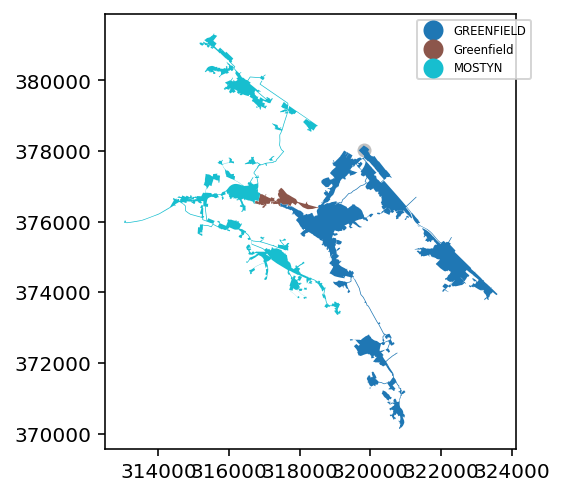

In [17]:
# Review treatment works that are unmatched (or a specific one of interest).
fig, ax = plt.subplots()
tp = uwwtps[uwwtps.uwwCode == 'UKWAWA_WW_TP000104'].iloc[0]
print(tp)
pt = tp.geometry
ax.scatter(pt.x, pt.y, color='silver')
delta = 2000
bbox = shapely.geometry.box(pt.x - delta, pt.y - delta, pt.x + delta, pt.y + delta)
nearby = catchments[catchments.intersects(bbox) & ~np.in1d(catchments.identifier, matched.identifier)]
nearby = catchments[catchments.intersects(bbox)]
nearby.plot(ax=ax, column='name', legend=True, legend_kwds={'fontsize': 'xx-small', 'bbox_to_anchor': (1.05, 1)})
uwwtps[uwwtps.intersects(bbox) & ~np.in1d(uwwtps.uwwCode, matched.uwwCode)].plot(marker='x', color='k', ax=ax)

for _, near in nearby.iterrows():
    print((near.identifier, near['name'], tp.uwwCode, tp.uwwName), ',', sep='')
print((None, None, tp.uwwCode, tp.uwwName), ',', sep='')

company                                        united_utilities
name                                           UU-09-SC47-DAVYH
reference                                      UU-09-SC47-DAVYH
comment                                                    None
identifier                                           214873b5cf
geometry      (POLYGON ((376849.7895 386400.9231, 376856.385...
Name: 5466, dtype: object
('103113a329', 'UU-07-SC38-DOCTO', 'UKENNW_UU_TP000042', 'Manchester and Salford (Davyhulme)STW')
('6050d31869', 'UU-07-SC40-HULTO', 'UKENNW_UU_TP000042', 'Manchester and Salford (Davyhulme)STW')
('87b079d5c8', 'UU-07-SC40-OVRHU', 'UKENNW_UU_TP000042', 'Manchester and Salford (Davyhulme)STW')
('e99e12ca5c', 'UU-10-SC51-PARKB', 'UKENNW_UU_TP000042', 'Manchester and Salford (Davyhulme)STW')
('b8815e3d28', 'UU-10-SC54-ARDEN', 'UKENNW_UU_TP000042', 'Manchester and Salford (Davyhulme)STW')
('b41dd6bfa5', 'UU-11-SC55-ASHLE', 'UKENNW_UU_TP000042', 'Manchester and Salford (Davyhulme)STW')
('

/Users/till/.pyenv/versions/3.9.2/envs/geomapping/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


,company,name,reference,comment,identifier,geometry
5440,united_utilities,UU-07-SC38-DOCTO,UU-07-SC38-DOCTO,None,103113a329,"POLYGON ((385453.857 408455.400, 385476.564 40..."
5448,united_utilities,UU-07-SC40-HULTO,UU-07-SC40-HULTO,None,6050d31869,"POLYGON ((368943.040 406956.719, 368965.120 40..."
5451,united_utilities,UU-07-SC40-OVRHU,UU-07-SC40-OVRHU,None,87b079d5c8,"POLYGON ((370495.478 405004.178, 370507.144 40..."
5478,united_utilities,UU-10-SC51-PARKB,UU-10-SC51-PARKB,None,e99e12ca5c,"POLYGON ((394119.030 402547.950, 394098.130 40..."
5494,united_utilities,UU-10-SC54-ARDEN,UU-10-SC54-ARDEN,None,b8815e3d28,"POLYGON ((392496.700 393428.300, 392544.200 39..."
5505,united_utilities,UU-11-SC55-ASHLE,UU-11-SC55-ASHLE,None,b41dd6bfa5,"POLYGON ((377610.850 384373.923, 377605.433 38..."
5509,united_utilities,UU-11-SC55-HGHLE,UU-11-SC55-HGHLE,None,af5ee2337b,"POLYGON ((370054.845 384457.499, 370056.082 38..."
5523,united_utilities,UU-11-SC56-HOOGR,UU-11-SC56-HOOGR,None,84e6bb9cc3,"POLYGON ((371863.094 382714.688, 371845.714 38..."


,uwwCode,uwwState,rptMStateKey,uwwName,uwwLatitude,uwwLongitude,uwwLoadEnteringUWWTP,uwwCapacity,version,year,geometry
838,UKENNW_UU_TP000042,active,UK,Manchester and Salford (Davyhulme)STW,53.464283,-2.381058,1108577.0,1206250.0,8,2018,POINT (374798.985 396460.950)
844,UKENNW_UU_TP000048,active,UK,FAILSWORTH STW,53.493999,-2.158243,21657.0,24215.0,8,2018,POINT (389598.981 399710.960)
901,UKENNW_UU_TP000105,active,UK,ROYTON STW,53.560264,-2.141296,29196.0,31294.0,8,2018,POINT (390737.976 407080.960)


<AxesSubplot:>

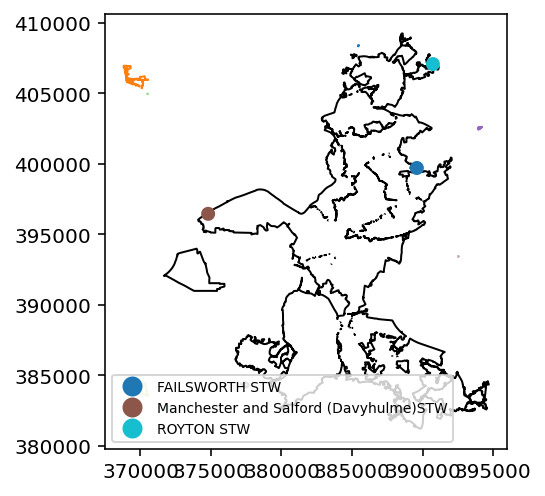

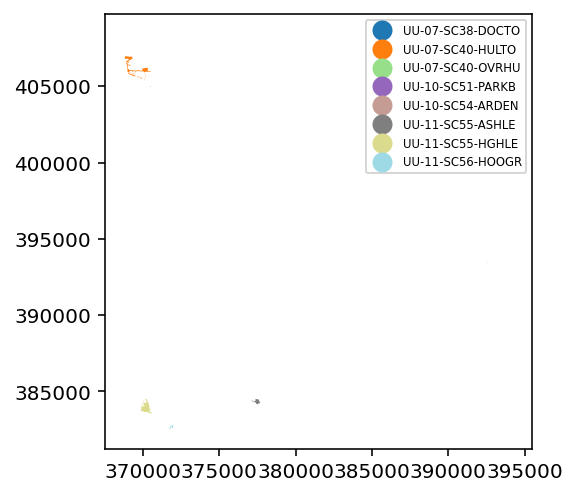

In [18]:
# Review catchments with many treatment works.
num_stps = binary.sum(axis=1)
idx = np.argsort(-num_stps)
num_stps = num_stps[idx]
offset = 0

# Plot the catchment area.
subset_catchments = catchments.iloc[[idx[offset]]]
ax = subset_catchments.plot(facecolor='none', edgecolor='k')
catchment = subset_catchments.iloc[0]
print(catchment)

# Plot the different treatment plants.
subset_uwwtps = uwwtps.iloc[binary[idx[offset]]]
subset_uwwtps.plot(column='uwwName', marker='o', ax=ax, zorder=9, legend=True, legend_kwds={
    'fontsize': 'x-small'
})

# Plot other catchments.
xlim = ax.get_xlim()
ylim = ax.get_ylim()

#catchments.plot(column='identifier', facecolor='none', edgecolor='face', ax=ax, zorder=1, ls=':')

#ax.set_xlim(xlim)
#ax.set_ylim(ylim)

bbox = shapely.geometry.box(xlim[0], ylim[0], xlim[1], ylim[1])
nearby = catchments.loc[catchments.intersects(bbox)]
nearby = nearby[~np.in1d(nearby.identifier, matched.identifier)]
nearby.plot(column='name', facecolor='none', edgecolor='face', ax=ax, cmap='tab20')

uwwtps[uwwtps.intersects(bbox) & ~np.in1d(uwwtps.uwwCode, matched.uwwCode)].plot(
    marker='x', color='k', ax=ax, zorder=10)

# Print something for us to copy for matches.
for _, row in subset_uwwtps.iterrows():
    for _, near in nearby.iterrows():
        print((near.identifier, near['name'], row.uwwCode, row.uwwName))
    print()
    
# Print something for us to copy for non-matches.
for _, row in subset_uwwtps.iterrows():
    print((None, None, row.uwwCode, row.uwwName))

display(nearby)
display(subset_uwwtps)

nearby.plot(column='name', legend=True, legend_kwds={'fontsize': 'xx-small'}, cmap='tab20')